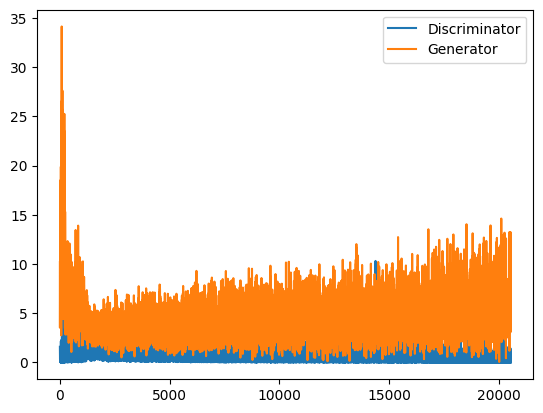

In [1]:
import pickle
import matplotlib.pyplot as plt

# Load the data
with open('./solutions/gan_D_loss.pkl', 'rb') as f:
    d_data = pickle.load(f)

with open('./solutions/gan_G_loss.pkl', 'rb') as f:
    g_data = pickle.load(f)

plt.plot(d_data, label='Discriminator')
plt.plot(g_data, label='Generator')
plt.legend()

In [2]:
with open('./solutions/gan_img_list.pkl', 'rb') as f:
    img_data = pickle.load(f)

len(img_data)

43

In [5]:
import torchvision.transforms.functional as tvtF
import imageio                                                                                                        

images = []           
for imgobj in img_data:  
    img = tvtF.to_pil_image(imgobj)  
    images.append(img) 
imageio.mimsave("./solutions/generation_animation.gif", images, fps=5)

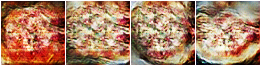

In [12]:
images[40]